# Trend Identification

Many factors can produce *non-stationarity* in annual maximum streamflow (AMS) data, including infrastructure, climate change, and land-use regulations.
This vignette demonstrates how to use the `ffaframework` to check for non-stationarity.

## Overview

**Mean Trend Tests**

| Function            | Purpose                                                       |
|---------------------|---------------------------------------------------------------|
| `eda_mk_test`       | Tests for a monotonic trend (Mann-Kendall).                   |
| `eda_bbmk_test`     | MK test adjusted for serial correlation via block bootstrapping. |
| `eda_sens_trend`    | Estimates slope and intercept of a linear trend (Sen's slope).|
| `eda_runs_test`     | Evaluates residual structure under linear model assumptions.  |

 **Stationarity Tests**

| Function            | Purpose                                                       |
|---------------------|---------------------------------------------------------------|
| `eda_spearman_test` | Tests for serial correlation.                                 |
| `eda_kpss_test`     | Tests for a unit root (with the PP test). |
| `eda_pp_test`       | Tests for a unit root (with the KPSS test). |

**Variance Trend Tests**

| Function            | Purpose                                                       |
|---------------------|---------------------------------------------------------------|
| MWMK Test           | Tests for a trend in the variance.                            |
| `eda_white_test`    | Tests for heteroskedasticity (time-dependence in variance).   |



## Setup 

In [1]:
library(ffaframework)

options(repr.plot.width = 10, repr.plot.height = 8, repr.plot.res = 150) # Set plot size

csv_path <- system.file("extdata", "Application_3.3.csv", package = "ffaframework")
df <- read.csv(csv_path)
df <- subset(df, !is.na(max)) # Remove missing values

head(df)

Loading required package: ggplot2

Loading required package: patchwork



,year,max
,<int>,<dbl>
22,1921,21.3
23,1922,24.4
24,1923,16.8
25,1924,28.6
26,1925,20.0
27,1926,21.8


## Mean Trend Tests

### Mann-Kendall (MK) Test

The MK test is a non-parametric test used to detect monotonic trends in a time series.
Under the null hypothesis there is no trend.

Pass a single vector of AMS measurements to `eda_mk_test()` to perform the MK test. 

In [2]:
mk_test <- eda_mk_test(df$max)

print(mk_test$p_value)

[1] 1.379613e-08


**Conclusion**: A p-value of $1.4 \times 10^{-8}$ provides strong evidence of a trend in the mean.



### Spearman Test

The Spearman test is used to check for *serial correlation*, which can cause the MK test to identify spurious trend.
The smallest lag at which the serial correlation is not statistically significant is known as the "least lag". 
If the least lag is greater than 1, apply the BBMK test to detect a monotonic trend under serial correlation.

[1] 5


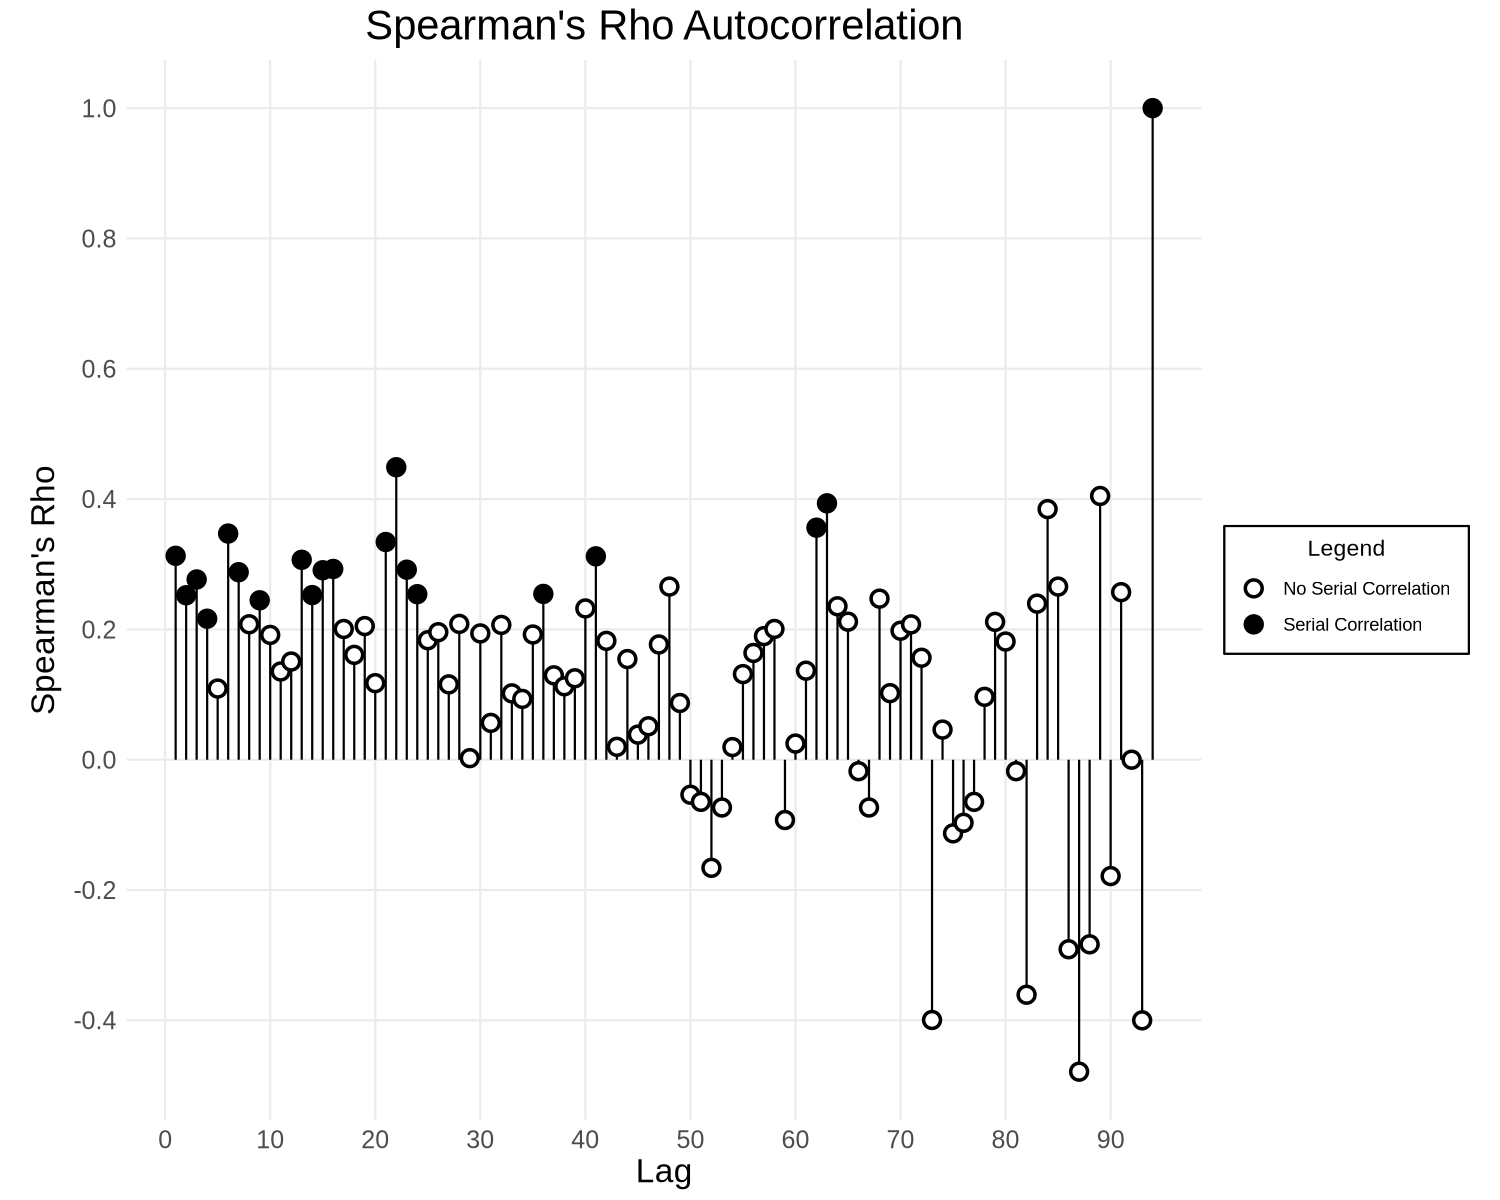

In [3]:
spearman_test <- eda_spearman_test(df$max)

print(spearman_test$least_lag)

plot_spearman_test(spearman_test)

**Conclusion**: A least lag of 5 is evidence of serial correlation.
The BBMK test is needed to re-evaluate the presence of a monotonic trend.



### Block-Bootstrap Mann-Kendall (BBMK) Test

The BBMK test is a modified version of the MK test that accounts for serial correlation.
Under the null hypothesis there is no trend.

[1] 0


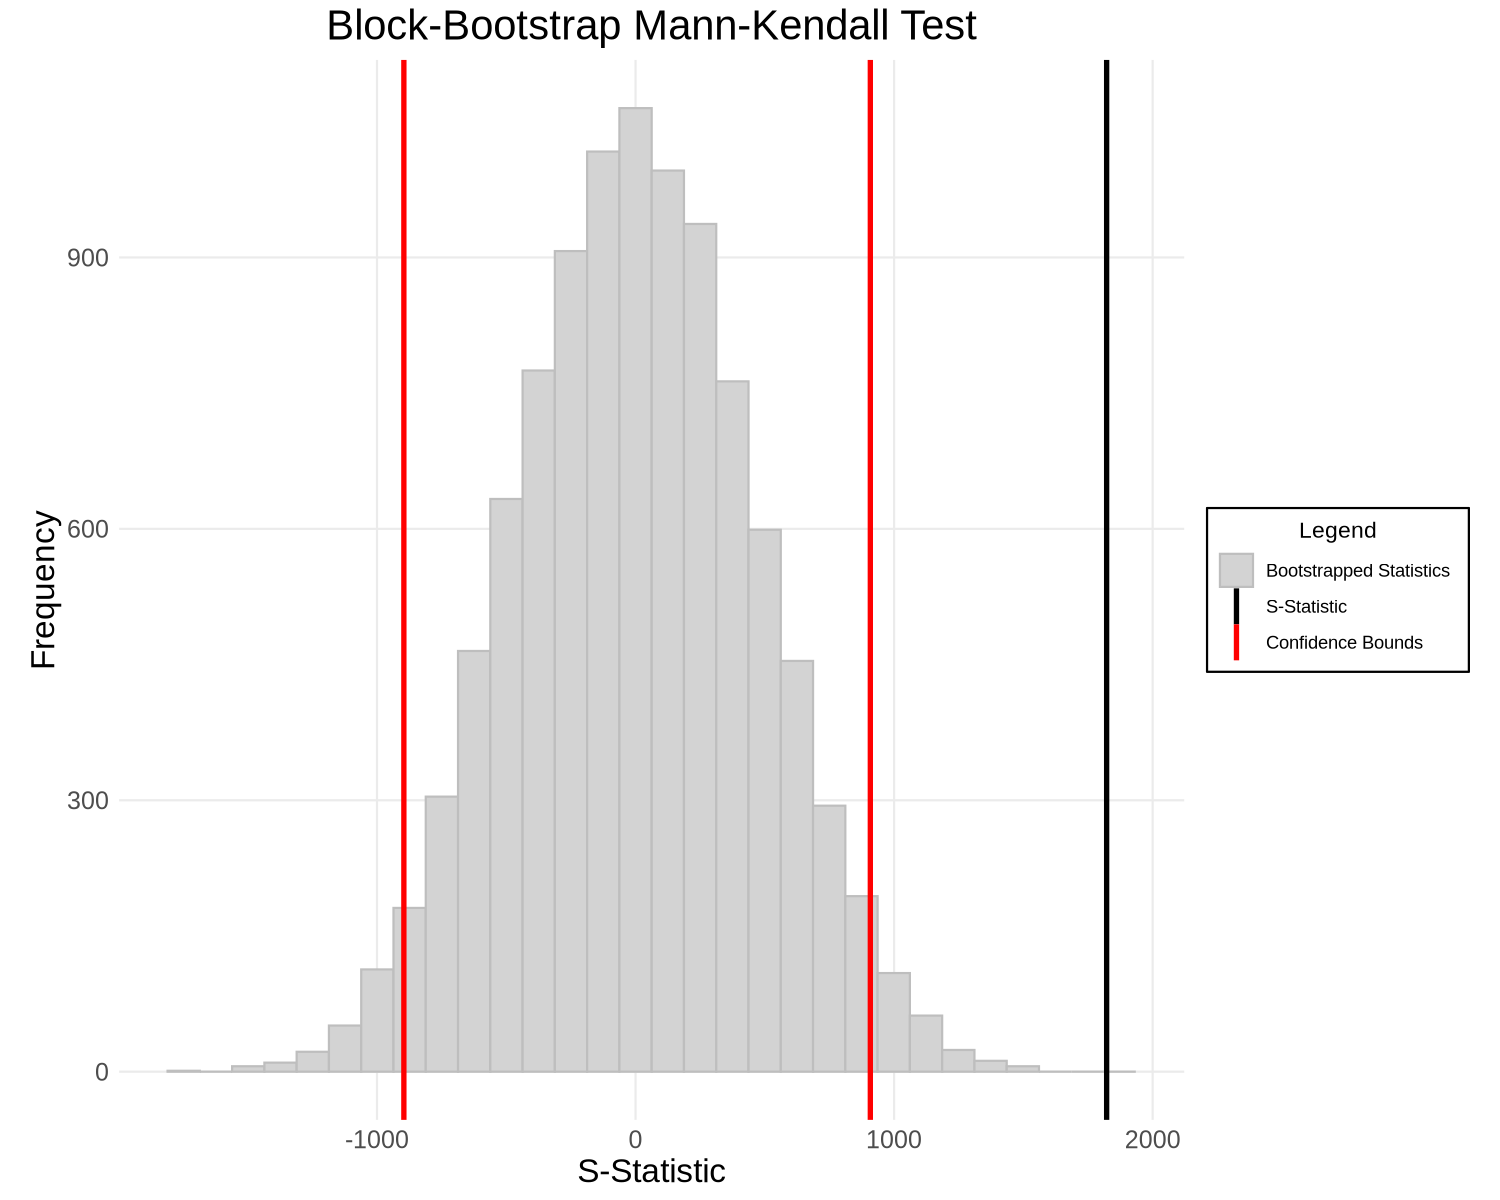

In [4]:
bbmk_test <- eda_bbmk_test(df$max)

print(bbmk_test$p_value)

plot_bbmk_test(bbmk_test)

**Conclusion**: There is strong evidence of a monotonic trend in the data, even after accounting for serial correlation.



### Sen's Trend Estimator

While the previous tests confirm a monotonic trend, they do not estimate its magnitude.
We can estimate the monotonic trend using Sen's trend estimator, which uses a non-parametric approach that is robust to outliers.

`eda_sens_trend()` takes two arguments: a numeric vector AMS streamflow observations and the corresponding vector of years.

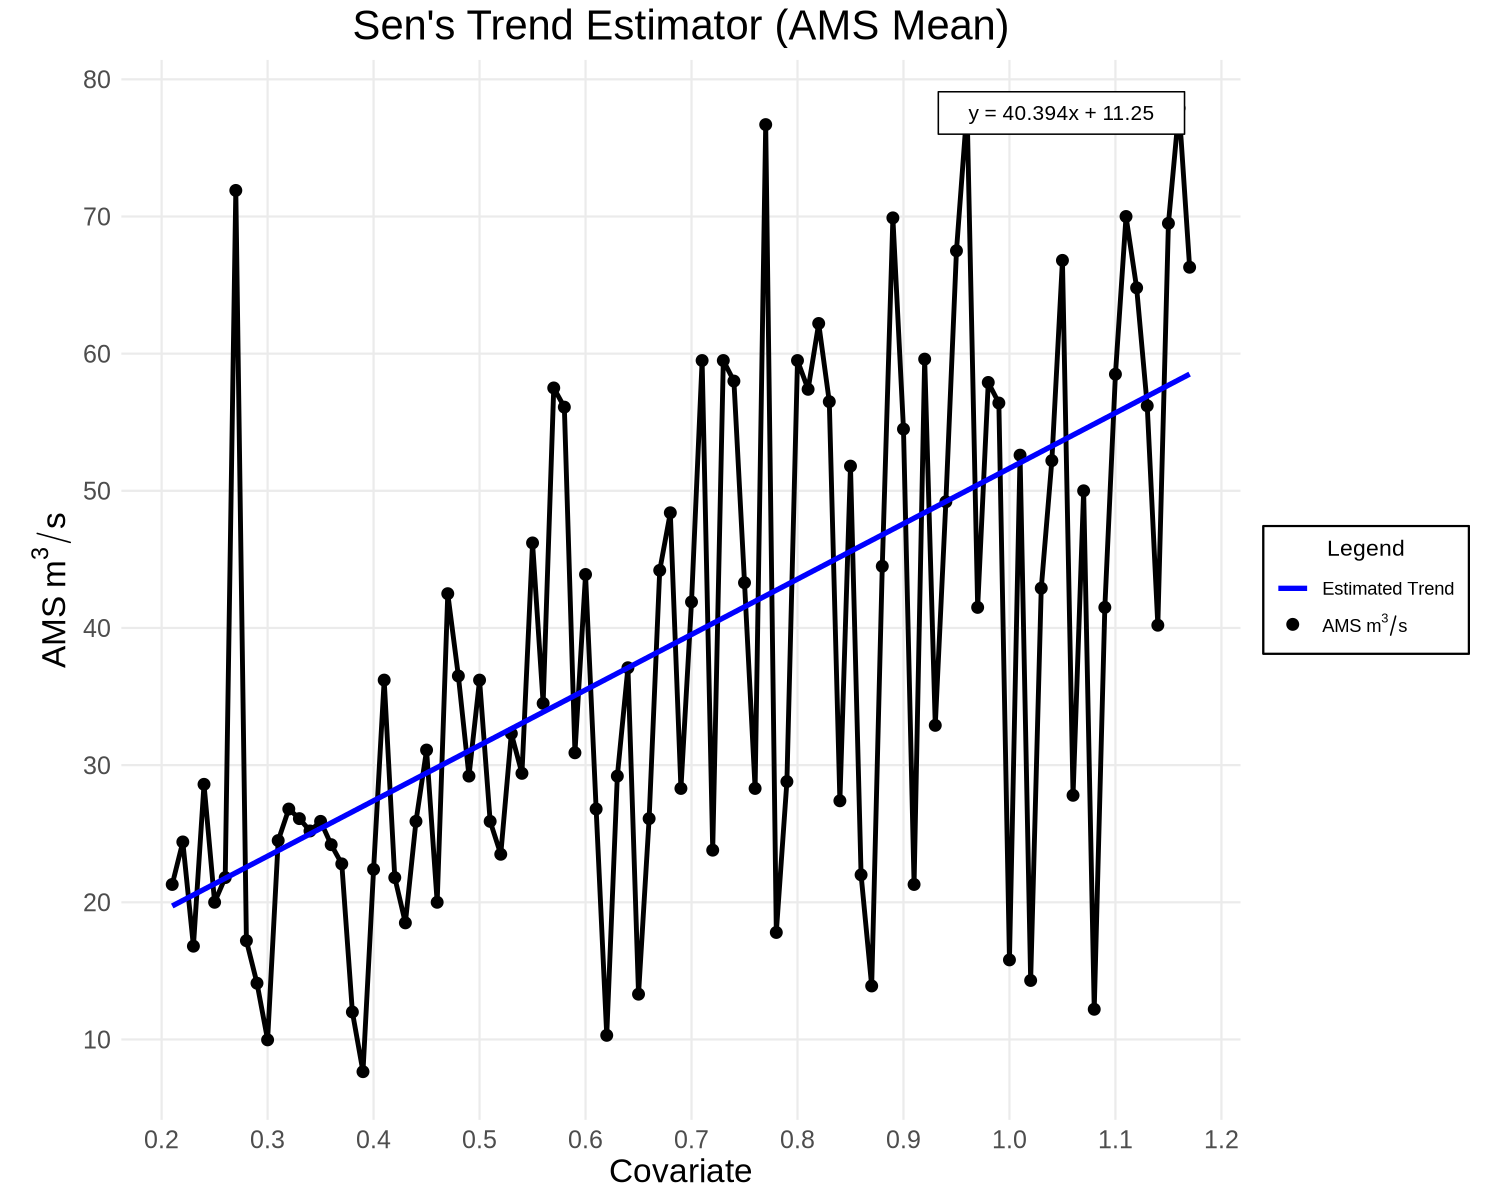

In [5]:
sens_trend <- eda_sens_trend(df$max, df$year)

plot_sens_trend(sens_trend, "mean")

**Conclusion**: Inspection of the data confirms the presence of a monotonic trend.



### Runs Test

The previous four statistical tests have assumed the non-stationarity is linear.
The Wald-Wolfowitz runs test detects non-linearity by checking the residuals for randomness.
If the residuals are random (the null hypothesis), there is evidence that the underlying trend is monotonic.

The `eda_runs_test()` function takes the output of `eda_sens_trend()` as an argument.

[1] 0.6815022


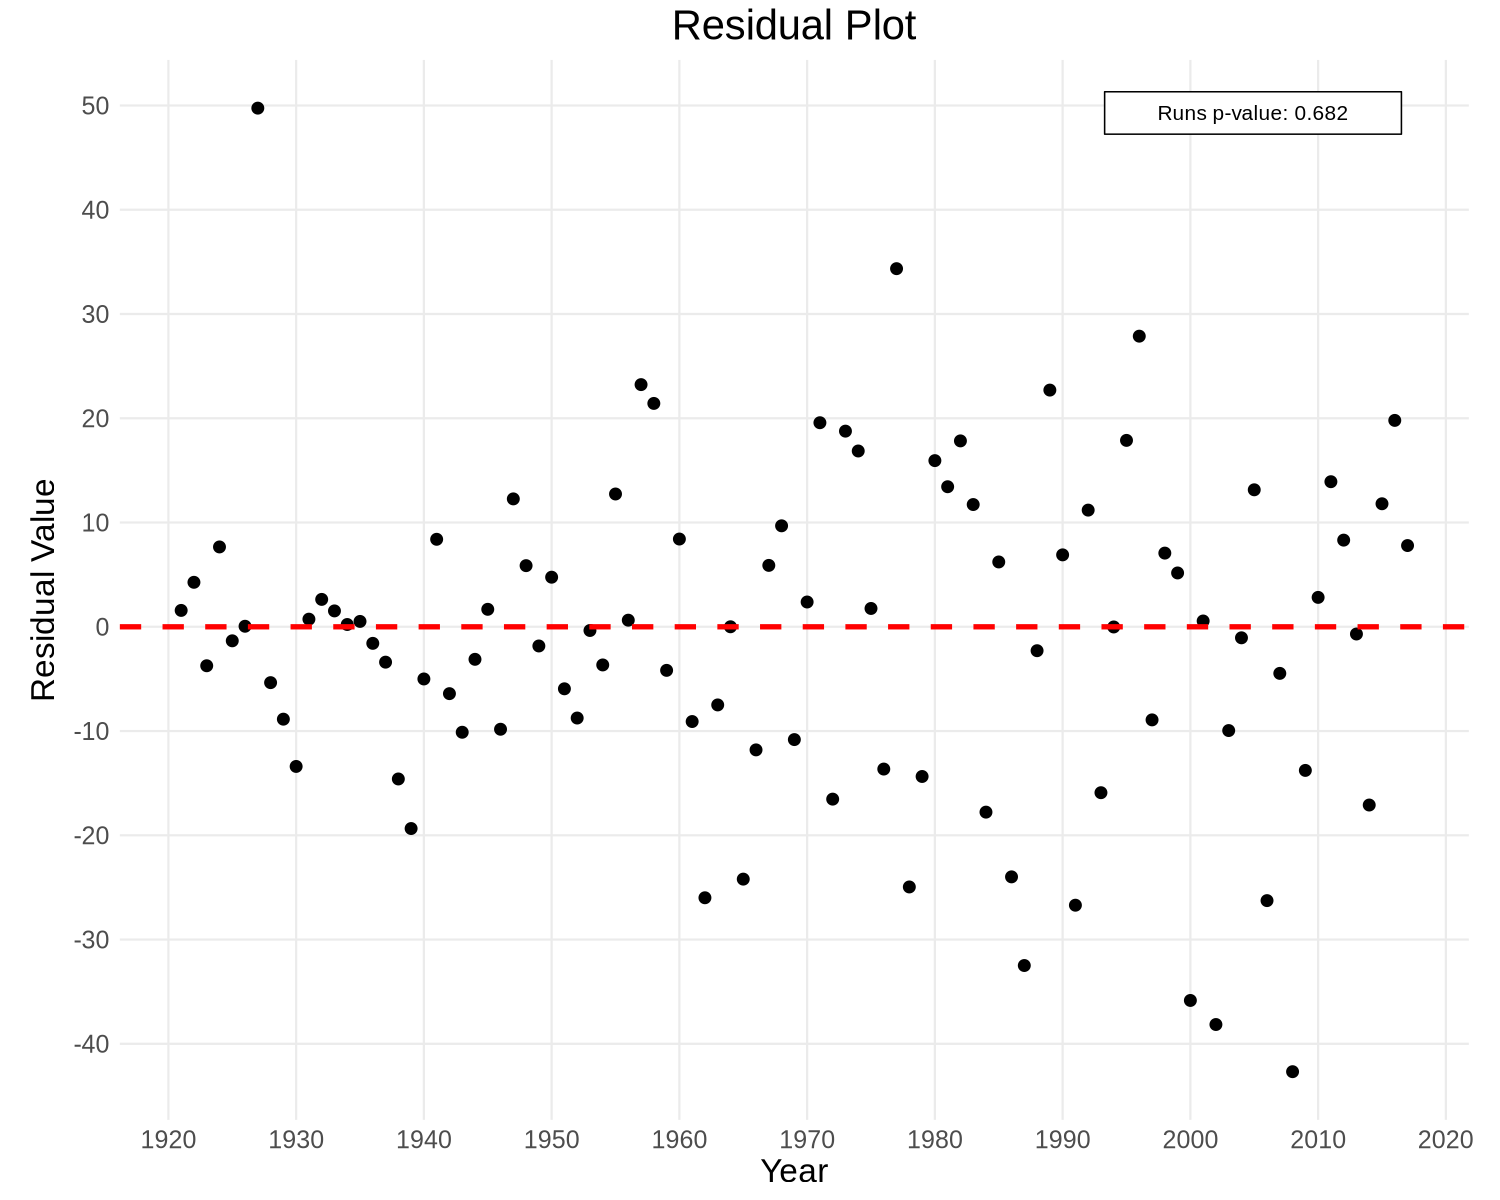

In [6]:
runs_test <- eda_runs_test(sens_trend)

print(runs_test$p_value)

plot_runs_test(runs_test, "mean")

**Conclusion**: At a p-value of $0.682$, there is evidence that a monotonic trend is suitable for the data.

## Trends in the Variance 

### Moving-Window Mann-Kendall (MWMK) Test

The MWMK test is used to detect trends in the variance of a time series.
First, a moving-window algorithm is used to estimate the variance of the AMS data.
Then, the Mann-Kendall test is applied to the series of variances to check for a trend.

The `ams_mw_variance` estimates the moving-window variances and the `eda_mk_test` function performs the Mann-Kendall test.

In [7]:
mw <- ams_mw_variance(df$max, df$year)
mwmk_test <- eda_mk_test(mw$std)
print(mwmk_test$p_value)

[1] 0.002443788


**Conclusion**: At a p-value of 0.0024, there is evidence of a monotonic trend in the variance. 



### White Test

The White test checks for *heteroskedasticity*, or general time-dependence in the variance.
The null hypothesis is *homoskedasticity*, or constant variance in the data.

In [8]:
white_test <- eda_white_test(df$max, df$year)
print(white_test$p_value)

[1] 0.133681


**Conclusion**: At a p-value of 0.13, there is no evidence of heteroskedasticity. 



## Conclusion

- Even after adjusting for serial correlation, **there is non-stationarity in the mean**.
- Additionally, the MWMK test provides evidence of **non-stationarity in the variance**. 

Flood frequency analysis of this dataset requires a time-dependent probability model.
